# 3

Deep Learning mengalami perkembangan yang sangat pesat dalam
beberapa tahun belakangan ini. Salah satunya dalam bidang Generative AI. Cikal bakal dari bidang
ini adalah arsitektur yang disebut sebagai generative adversarial network (GAN).

## a

Penjelasan cara kerja dari arsitektur tersebut yang dideskripsikan dalam
gambar di bawah ini:

![alt text](image.png)

Arsitektur Generative Adversarial Networks (GAN) yang digambarkan dalam gambar terdiri dari dua jaringan saraf utama: generator dan discriminator.

Generator menerima input berupa vektor acak yang disebut noise. Noise ini dapat berasal dari distribusi acak apa pun, seperti distribusi normal atau seragam. Generator kemudian memproses noise ini untuk menghasilkan gambar baru.

Discriminator menerima input berupa gambar, baik gambar asli dari dataset pelatihan maupun gambar yang dihasilkan oleh generator. Discriminator kemudian memproses gambar ini untuk menentukan apakah gambar tersebut asli atau palsu.

Kedua jaringan ini dilatih secara bersamaan dalam proses yang adversarial. Generator berusaha untuk menghasilkan gambar yang realistis sehingga discriminator tidak dapat membedakannya dari gambar asli. Discriminator, di sisi lain, berusaha untuk meningkatkan kemampuannya dalam membedakan gambar asli dari gambar palsu.

**Proses pelatihan GAN dapat dibagi menjadi beberapa langkah:**

- **Generate**: Generator menghasilkan gambar baru dari noise acak.
- **Discriminate**: Discriminator menerima gambar dari generator dan gambar asli dari dataset pelatihan. Discriminator kemudian menentukan apakah gambar tersebut asli atau palsu.
- **Update**: Bobot generator dan discriminator diperbarui berdasarkan hasil dari langkah 2.
Proses ini diulang secara berulang hingga generator mampu menghasilkan gambar yang realistis dan discriminator tidak dapat lagi membedakannya dari gambar asli.

<br>

**Loss function GAN:**

![alt text](image-1.png)

Formula loss diatas serupa dengan binary crossentropy.

Dalam formula ini:
- D(x) adalah estimasi diskriminator dari probabilitas bahwa instance data real x adalah asli.
- G(z) adalah output generator ketika diberikan noise z.
- D(G(z)) adalah estimasi diskriminator dari probabilitas bahwa instance palsu adalah asli.

<br>

![alt text](image-2.png)

**Rumus diatas merupakan binary crossentropy loss.**

Ketika p=1, yakni ground truth merupakan gambar asli maka akan seperti ini:
<br>

**Binary Cross entropy Loss = -log(D(x))**

<br>
Ketika p=0, yakni ground truth merupakan gambar palsu maka akan seperti ini:
<br>

**Binary Cross entropy Loss = -log(1-D(g(z)))**

<br>
Generator tidak dapat secara langsung mempengaruhi istilah log(D(x)) dalam fungsi tersebut, sehingga, bagi generator, meminimalkan loss ekuivalen dengan meminimalkan hasil log(1 - D(G(z))).

## b

Membuat arsitektur untuk image generation sesuai dengan gambar arsitektur GAN berikut ini. Lakukan evaluasi image distribution similarity dengan menggunakan Fréchet Inception Distance (FID) pada data test.

![alt text](image-4.png)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Embedding, concatenate, Input, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np
from skimage.transform import resize
from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm

In [ ]:
import numpy as np
import idx2numpy

# Konversi data gambar dan label menjadi array numpy
train_img = 'train-images-idx3-ubyte'
train_label = 'train-labels-idx1-ubyte'

In [ ]:
train_img_arr = idx2numpy.convert_from_file(train_img)
train_label_arr = idx2numpy.convert_from_file(train_label)

# Ambil index label berdasarkan label 0 (T-shirt/top) dan 1 (Trouser)
indx = np.where((train_label_arr == 0) | (train_label_arr == 1))[0]

# Filter data berdasarkan index yang didapat
filter_img_data = train_img_arr[indx]
filter_label_data = train_label_arr[indx]

print('Filtered data (T-shirt/top and trouser):')
print('Image data  : ', filter_img_data.shape)
print('Label data:', filter_label_data.shape)

Filtered data (T-shirt/top and trouser):
Image data  :  (12000, 28, 28)
Label data: (12000,)


In [ ]:
# Scaling data dari -1 ke 1
filter_img_data = filter_img_data.astype(float)
filter_img_data /= 255.0
filter_img_data = (filter_img_data * 2) - 1

# Ubah bentuk data gambar
filter_img_data = filter_img_data.reshape(-1, 28, 28, 1)

generator

In [ ]:
total_class = 2
noise_dim = 50
img_shape = 28

def build_generator(noise_dim, img_shape, total_class):
    label_input = Input(shape=(1,))
    noise_input = Input(shape=(noise_dim,))

    lab_embed = Embedding(total_class, noise_dim)(label_input)
    lab_embed = Flatten()(lab_embed)
    generator = Concatenate()([noise_input, lab_embed])

    generator = Dense(128)(generator)
    generator = Dense(256)(generator)
    generator = Dense(512)(generator)
    generator = Dense(1024)(generator)

    generator = Dense(img_shape * img_shape, activation='tanh')(generator)
    generator = Reshape((img_shape, img_shape, 1))(generator)

    model = Model([noise_input, label_input], generator, name='generator')
    return model

generator_model = build_generator(noise_dim, img_shape, total_class)
generator_model.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                100       ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 flatten (Flatten)           (None, 50)                   0         ['embedding[0][0]']           
                                                                                          

Discriminator

In [ ]:
def build_discriminator(img_shape, total_class):
    img_input = Input(shape=(img_shape, img_shape, 1))
    label_input = Input(shape=(1,))

    lab_embed = Embedding(total_class, img_shape * img_shape)(label_input)
    lab_embed = Flatten()(lab_embed)
    lab_embed = Reshape((img_shape, img_shape, 1))(lab_embed)

    discriminator = Concatenate()([img_input, lab_embed])
    discriminator = Flatten()(discriminator)

    discriminator = Dense(512)(discriminator)
    discriminator = Dense(1024)(discriminator)
    discriminator = Dense(1024)(discriminator)
    discriminator = Dense(512)(discriminator)
    discriminator = Dense(1, activation='sigmoid')(discriminator)

    model = Model([img_input, label_input], discriminator, name='discriminator')
    model.compile(optimizer=Adam(learning_rate=0.00005, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

discriminator_model = build_discriminator(img_shape, total_class)
discriminator_model.summary()


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 784)               1568      ['input_4[0][0]']             
                                                                                                  
 flatten_1 (Flatten)         (None, 784)                  0         ['embedding_1[0][0]']         
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                      

Combine

In [ ]:
def build_gan(generator, discriminator, noise_dim):
    discriminator.trainable = False

    noise_input = Input(shape=(noise_dim,))
    label_input = Input(shape=(1,))

    generated_image = generator([noise_input, label_input])
    validity = discriminator([generated_image, label_input])

    model = Model([noise_input, label_input], validity, name='GAN')
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00005, beta_1=0.5))
    return model

gan_model = build_gan(generator_model, discriminator_model, noise_dim)
gan_model.summary()


Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 generator (Functional)      (None, 28, 28, 1)            1506548   ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 discriminator (Functional)  (None, 1)                    2905121   ['generator[0][0]',         

train

1/1 [==============================] - 0s 381ms/step


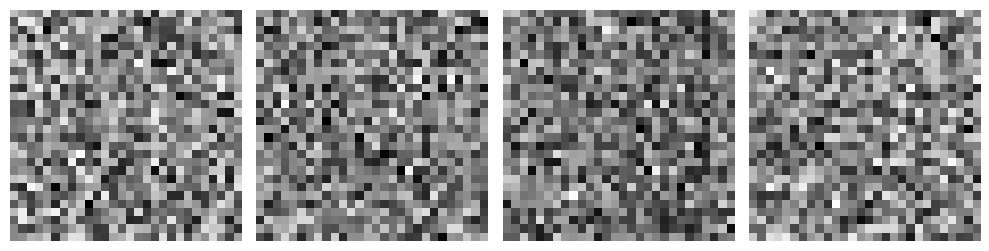

2/2 [==============================] - 0s 9ms/step
Epoch: 1, Batch: 0, D Loss: 0.9346866309642792, D Acc: 0.20000000298023224, G Loss: 0.6652387976646423
2/2 [==============================] - 0s 6ms/step
Epoch: 1, Batch: 50, D Loss: 0.4068308211863041, D Acc: 0.5, G Loss: 2.794557809829712
2/2 [==============================] - 0s 8ms/step
Epoch: 1, Batch: 100, D Loss: 0.27761125937104225, D Acc: 0.5, G Loss: 3.2795472145080566
2/2 [==============================] - 0s 5ms/step
Epoch: 2, Batch: 0, D Loss: 0.19561665505170822, D Acc: 0.5, G Loss: 4.032303333282471
2/2 [==============================] - 0s 10ms/step
Epoch: 2, Batch: 50, D Loss: 0.22597488574683666, D Acc: 0.5, G Loss: 3.6786248683929443
2/2 [==============================] - 0s 7ms/step
Epoch: 2, Batch: 100, D Loss: 0.7810357809066772, D Acc: 0.33000001311302185, G Loss: 3.8245010375976562
2/2 [==============================] - 0s 8ms/step
Epoch: 3, Batch: 0, D Loss: 0.44313836097717285, D Acc: 0.46000000834465027, G Lo

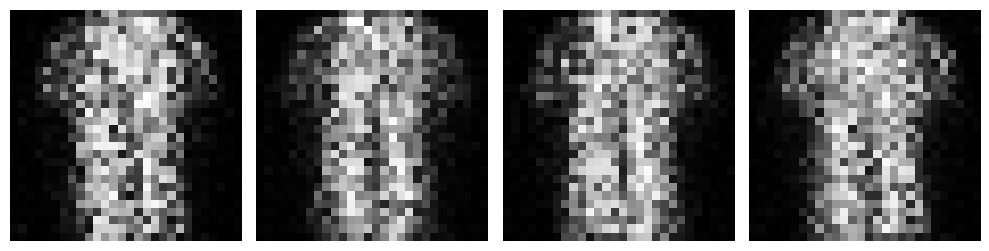

2/2 [==============================] - 0s 6ms/step
Epoch: 11, Batch: 0, D Loss: 0.682998538017273, D Acc: 0.4300000071525574, G Loss: 0.878903329372406
2/2 [==============================] - 0s 5ms/step
Epoch: 11, Batch: 50, D Loss: 0.6835698783397675, D Acc: 0.4699999988079071, G Loss: 0.9014268517494202
2/2 [==============================] - 0s 5ms/step
Epoch: 11, Batch: 100, D Loss: 0.7164372503757477, D Acc: 0.4099999964237213, G Loss: 0.8531579375267029
2/2 [==============================] - 0s 7ms/step
Epoch: 12, Batch: 0, D Loss: 0.7088024914264679, D Acc: 0.36000001430511475, G Loss: 0.8505097031593323
2/2 [==============================] - 0s 4ms/step
Epoch: 12, Batch: 50, D Loss: 0.6805679798126221, D Acc: 0.47999998927116394, G Loss: 0.9125407338142395
2/2 [==============================] - 0s 10ms/step
Epoch: 12, Batch: 100, D Loss: 0.7110764682292938, D Acc: 0.36000001430511475, G Loss: 0.8279203176498413
2/2 [==============================] - 0s 7ms/step
Epoch: 13, Batch:

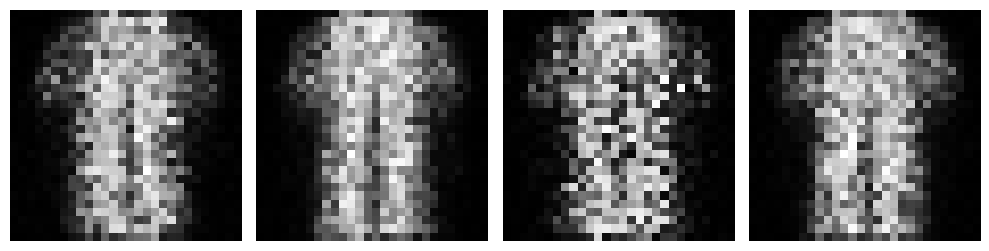

2/2 [==============================] - 0s 4ms/step
Epoch: 21, Batch: 0, D Loss: 0.6989236772060394, D Acc: 0.4699999988079071, G Loss: 0.834646463394165
2/2 [==============================] - 0s 6ms/step
Epoch: 21, Batch: 50, D Loss: 0.6931388080120087, D Acc: 0.4699999988079071, G Loss: 0.8291601538658142
2/2 [==============================] - 0s 4ms/step
Epoch: 21, Batch: 100, D Loss: 0.6823433041572571, D Acc: 0.47999998927116394, G Loss: 0.8614488244056702
2/2 [==============================] - 0s 8ms/step
Epoch: 22, Batch: 0, D Loss: 0.694891482591629, D Acc: 0.4099999964237213, G Loss: 0.8280534148216248
2/2 [==============================] - 0s 4ms/step
Epoch: 22, Batch: 50, D Loss: 0.6991758942604065, D Acc: 0.4699999988079071, G Loss: 0.8397219777107239
2/2 [==============================] - 0s 5ms/step
Epoch: 22, Batch: 100, D Loss: 0.687764585018158, D Acc: 0.47999998927116394, G Loss: 0.8377247452735901
2/2 [==============================] - 0s 4ms/step
Epoch: 23, Batch: 0,

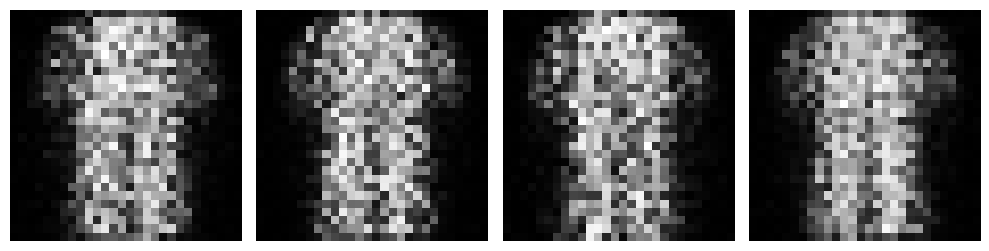

2/2 [==============================] - 0s 4ms/step
Epoch: 31, Batch: 0, D Loss: 0.6905787289142609, D Acc: 0.5, G Loss: 0.826941728591919
2/2 [==============================] - 0s 9ms/step
Epoch: 31, Batch: 50, D Loss: 0.7001377642154694, D Acc: 0.44999998807907104, G Loss: 0.833513617515564
2/2 [==============================] - 0s 5ms/step
Epoch: 31, Batch: 100, D Loss: 0.6958981156349182, D Acc: 0.49000000953674316, G Loss: 0.8247531652450562
2/2 [==============================] - 0s 5ms/step
Epoch: 32, Batch: 0, D Loss: 0.6982734203338623, D Acc: 0.5, G Loss: 0.8140237331390381
2/2 [==============================] - 0s 5ms/step
Epoch: 32, Batch: 50, D Loss: 0.6911228001117706, D Acc: 0.5, G Loss: 0.821492612361908
2/2 [==============================] - 0s 10ms/step
Epoch: 32, Batch: 100, D Loss: 0.7108054459095001, D Acc: 0.41999998688697815, G Loss: 0.8288516402244568
2/2 [==============================] - 0s 7ms/step
Epoch: 33, Batch: 0, D Loss: 0.7022575736045837, D Acc: 0.46999

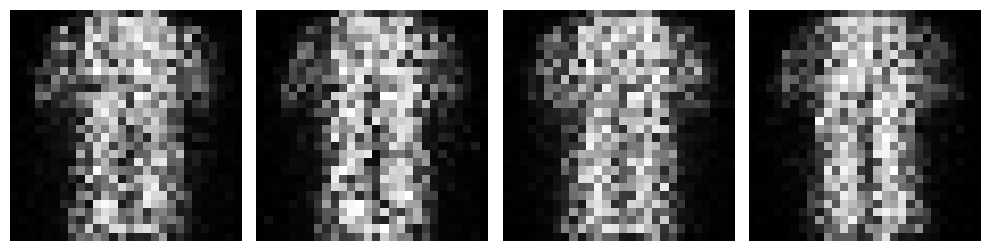

2/2 [==============================] - 0s 5ms/step
Epoch: 41, Batch: 0, D Loss: 0.701246976852417, D Acc: 0.47999998927116394, G Loss: 0.8116160035133362
2/2 [==============================] - 0s 6ms/step
Epoch: 41, Batch: 50, D Loss: 0.7103091776371002, D Acc: 0.4099999964237213, G Loss: 0.8477718830108643
2/2 [==============================] - 0s 4ms/step
Epoch: 41, Batch: 100, D Loss: 0.7016775608062744, D Acc: 0.49000000953674316, G Loss: 0.8434317111968994
2/2 [==============================] - 0s 7ms/step
Epoch: 42, Batch: 0, D Loss: 0.7149833738803864, D Acc: 0.4300000071525574, G Loss: 0.8429259657859802
2/2 [==============================] - 0s 5ms/step
Epoch: 42, Batch: 50, D Loss: 0.6913658380508423, D Acc: 0.47999998927116394, G Loss: 0.8410816788673401
2/2 [==============================] - 0s 7ms/step
Epoch: 42, Batch: 100, D Loss: 0.6967517733573914, D Acc: 0.5, G Loss: 0.8543477654457092
2/2 [==============================] - 0s 6ms/step
Epoch: 43, Batch: 0, D Loss: 0.6

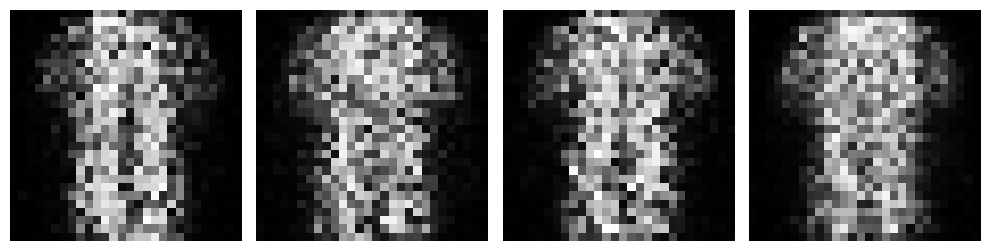

2/2 [==============================] - 0s 7ms/step
Epoch: 51, Batch: 0, D Loss: 0.6979407370090485, D Acc: 0.4699999988079071, G Loss: 0.8393651843070984
2/2 [==============================] - 0s 4ms/step
Epoch: 51, Batch: 50, D Loss: 0.6940188705921173, D Acc: 0.47999998927116394, G Loss: 0.8416314721107483
2/2 [==============================] - 0s 4ms/step
Epoch: 51, Batch: 100, D Loss: 0.6984055936336517, D Acc: 0.47999998927116394, G Loss: 0.8171120285987854
2/2 [==============================] - 0s 5ms/step
Epoch: 52, Batch: 0, D Loss: 0.7102744877338409, D Acc: 0.3799999952316284, G Loss: 0.8349447846412659
2/2 [==============================] - 0s 7ms/step
Epoch: 52, Batch: 50, D Loss: 0.7012530565261841, D Acc: 0.47999998927116394, G Loss: 0.8600596785545349
2/2 [==============================] - 0s 5ms/step
Epoch: 52, Batch: 100, D Loss: 0.6850130558013916, D Acc: 0.49000000953674316, G Loss: 0.8263644576072693
2/2 [==============================] - 0s 5ms/step
Epoch: 53, Batc

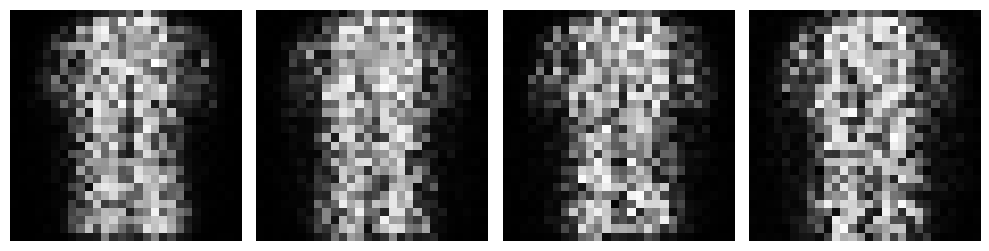

2/2 [==============================] - 0s 4ms/step
Epoch: 61, Batch: 0, D Loss: 0.6960472166538239, D Acc: 0.46000000834465027, G Loss: 0.8116554021835327
2/2 [==============================] - 0s 4ms/step
Epoch: 61, Batch: 50, D Loss: 0.7002495229244232, D Acc: 0.41999998688697815, G Loss: 0.8343381285667419
2/2 [==============================] - 0s 5ms/step
Epoch: 61, Batch: 100, D Loss: 0.6963188052177429, D Acc: 0.49000000953674316, G Loss: 0.8237749338150024
2/2 [==============================] - 0s 4ms/step
Epoch: 62, Batch: 0, D Loss: 0.7057048678398132, D Acc: 0.46000000834465027, G Loss: 0.8198452591896057
2/2 [==============================] - 0s 5ms/step
Epoch: 62, Batch: 50, D Loss: 0.7001665234565735, D Acc: 0.49000000953674316, G Loss: 0.8233203887939453
2/2 [==============================] - 0s 4ms/step
Epoch: 62, Batch: 100, D Loss: 0.6908475756645203, D Acc: 0.5, G Loss: 0.8199552893638611
2/2 [==============================] - 0s 7ms/step
Epoch: 63, Batch: 0, D Loss: 

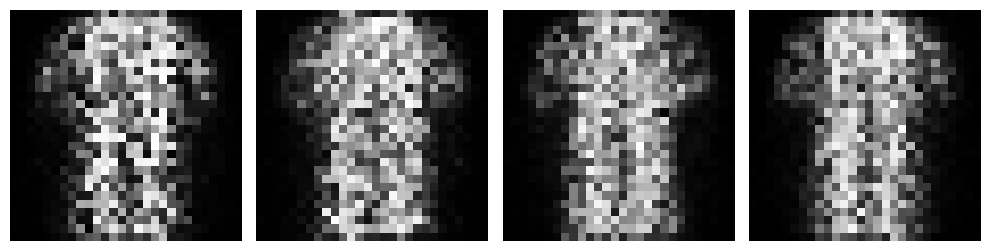

2/2 [==============================] - 0s 5ms/step
Epoch: 71, Batch: 0, D Loss: 0.6974330842494965, D Acc: 0.49000000953674316, G Loss: 0.805849015712738
2/2 [==============================] - 0s 5ms/step
Epoch: 71, Batch: 50, D Loss: 0.6866925656795502, D Acc: 0.5, G Loss: 0.8209919929504395
2/2 [==============================] - 0s 5ms/step
Epoch: 71, Batch: 100, D Loss: 0.7021985352039337, D Acc: 0.46000000834465027, G Loss: 0.831615149974823
2/2 [==============================] - 0s 5ms/step
Epoch: 72, Batch: 0, D Loss: 0.6909411251544952, D Acc: 0.5, G Loss: 0.8077969551086426
2/2 [==============================] - 0s 6ms/step
Epoch: 72, Batch: 50, D Loss: 0.695860892534256, D Acc: 0.5, G Loss: 0.8127548098564148
2/2 [==============================] - 0s 5ms/step
Epoch: 72, Batch: 100, D Loss: 0.6894796788692474, D Acc: 0.5, G Loss: 0.8156610131263733
2/2 [==============================] - 0s 4ms/step
Epoch: 73, Batch: 0, D Loss: 0.7012854814529419, D Acc: 0.46000000834465027, G L

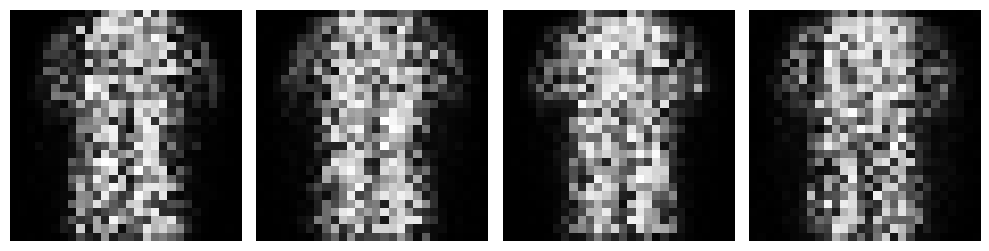

2/2 [==============================] - 0s 5ms/step
Epoch: 81, Batch: 0, D Loss: 0.6914215981960297, D Acc: 0.5, G Loss: 0.835684597492218
2/2 [==============================] - 0s 4ms/step
Epoch: 81, Batch: 50, D Loss: 0.6914252042770386, D Acc: 0.49000000953674316, G Loss: 0.8144827485084534
2/2 [==============================] - 0s 6ms/step
Epoch: 81, Batch: 100, D Loss: 0.6894502639770508, D Acc: 0.5, G Loss: 0.8012349009513855
2/2 [==============================] - 0s 5ms/step
Epoch: 82, Batch: 0, D Loss: 0.6968032717704773, D Acc: 0.5, G Loss: 0.7983891367912292
2/2 [==============================] - 0s 5ms/step
Epoch: 82, Batch: 50, D Loss: 0.6972666680812836, D Acc: 0.46000000834465027, G Loss: 0.814146101474762
2/2 [==============================] - 0s 6ms/step
Epoch: 82, Batch: 100, D Loss: 0.6886292695999146, D Acc: 0.5, G Loss: 0.8050594925880432
2/2 [==============================] - 0s 5ms/step
Epoch: 83, Batch: 0, D Loss: 0.6934821009635925, D Acc: 0.5, G Loss: 0.80731201

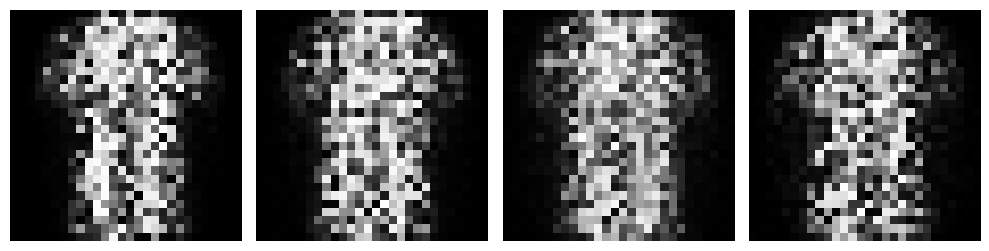

2/2 [==============================] - 0s 4ms/step
Epoch: 91, Batch: 0, D Loss: 0.6931844055652618, D Acc: 0.5, G Loss: 0.7991229891777039
2/2 [==============================] - 0s 5ms/step
Epoch: 91, Batch: 50, D Loss: 0.6933687031269073, D Acc: 0.46000000834465027, G Loss: 0.8050594925880432
2/2 [==============================] - 0s 6ms/step
Epoch: 91, Batch: 100, D Loss: 0.6920286118984222, D Acc: 0.5, G Loss: 0.7987387180328369
2/2 [==============================] - 0s 4ms/step
Epoch: 92, Batch: 0, D Loss: 0.6916406154632568, D Acc: 0.5, G Loss: 0.8141446709632874
2/2 [==============================] - 0s 5ms/step
Epoch: 92, Batch: 50, D Loss: 0.6968307197093964, D Acc: 0.5, G Loss: 0.8084495663642883
2/2 [==============================] - 0s 6ms/step
Epoch: 92, Batch: 100, D Loss: 0.6930095553398132, D Acc: 0.5, G Loss: 0.8130437731742859
2/2 [==============================] - 0s 5ms/step
Epoch: 93, Batch: 0, D Loss: 0.6902525126934052, D Acc: 0.5, G Loss: 0.8109100461006165
2/2 [

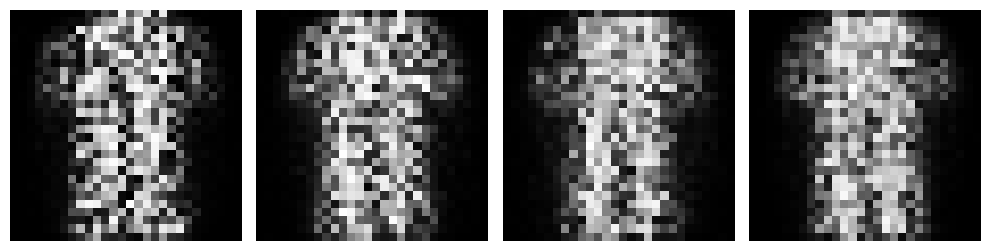

2/2 [==============================] - 0s 5ms/step
Epoch: 101, Batch: 0, D Loss: 0.6904313266277313, D Acc: 0.5, G Loss: 0.8132964968681335
2/2 [==============================] - 0s 6ms/step
Epoch: 101, Batch: 50, D Loss: 0.6881693601608276, D Acc: 0.5, G Loss: 0.8176117539405823
2/2 [==============================] - 0s 5ms/step
Epoch: 101, Batch: 100, D Loss: 0.6911113262176514, D Acc: 0.5, G Loss: 0.8066564798355103
2/2 [==============================] - 0s 5ms/step
Epoch: 102, Batch: 0, D Loss: 0.697213888168335, D Acc: 0.49000000953674316, G Loss: 0.8033926486968994
2/2 [==============================] - 0s 5ms/step
Epoch: 102, Batch: 50, D Loss: 0.6958835422992706, D Acc: 0.49000000953674316, G Loss: 0.8023475408554077
2/2 [==============================] - 0s 4ms/step
Epoch: 102, Batch: 100, D Loss: 0.6955288946628571, D Acc: 0.5, G Loss: 0.804863691329956
2/2 [==============================] - 0s 5ms/step
Epoch: 103, Batch: 0, D Loss: 0.6928977072238922, D Acc: 0.5, G Loss: 0.8

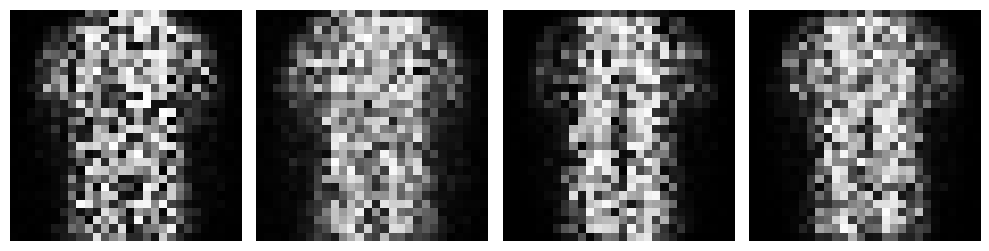

2/2 [==============================] - 0s 6ms/step
Epoch: 111, Batch: 0, D Loss: 0.6923179924488068, D Acc: 0.5, G Loss: 0.7967303991317749
2/2 [==============================] - 0s 5ms/step
Epoch: 111, Batch: 50, D Loss: 0.6909402012825012, D Acc: 0.5, G Loss: 0.7909899353981018
2/2 [==============================] - 0s 5ms/step
Epoch: 111, Batch: 100, D Loss: 0.6882781386375427, D Acc: 0.5, G Loss: 0.8011739253997803
2/2 [==============================] - 0s 4ms/step
Epoch: 112, Batch: 0, D Loss: 0.6909195184707642, D Acc: 0.5, G Loss: 0.7931617498397827
2/2 [==============================] - 0s 4ms/step
Epoch: 112, Batch: 50, D Loss: 0.6903683245182037, D Acc: 0.47999998927116394, G Loss: 0.8061010837554932
2/2 [==============================] - 0s 4ms/step
Epoch: 112, Batch: 100, D Loss: 0.6871452331542969, D Acc: 0.46000000834465027, G Loss: 0.8204147219657898
2/2 [==============================] - 0s 9ms/step
Epoch: 113, Batch: 0, D Loss: 0.6978636085987091, D Acc: 0.5, G Loss: 0

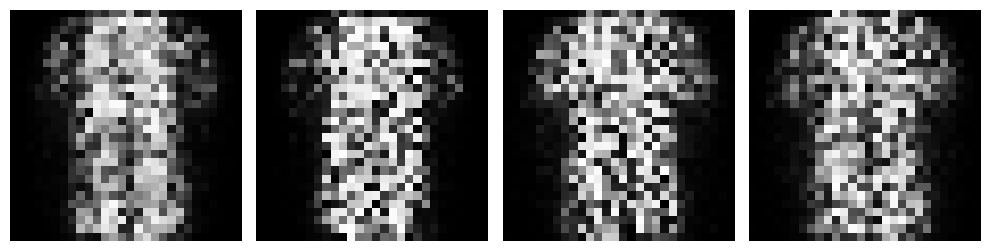

2/2 [==============================] - 0s 4ms/step
Epoch: 121, Batch: 0, D Loss: 0.696144163608551, D Acc: 0.5, G Loss: 0.8070909976959229
2/2 [==============================] - 0s 5ms/step
Epoch: 121, Batch: 50, D Loss: 0.6881352066993713, D Acc: 0.5, G Loss: 0.7991114854812622
2/2 [==============================] - 0s 6ms/step
Epoch: 121, Batch: 100, D Loss: 0.6912688314914703, D Acc: 0.5, G Loss: 0.8059185147285461
2/2 [==============================] - 0s 5ms/step
Epoch: 122, Batch: 0, D Loss: 0.6895142495632172, D Acc: 0.5, G Loss: 0.8053936958312988
2/2 [==============================] - 0s 4ms/step
Epoch: 122, Batch: 50, D Loss: 0.690078467130661, D Acc: 0.5, G Loss: 0.7949974536895752
2/2 [==============================] - 0s 5ms/step
Epoch: 122, Batch: 100, D Loss: 0.6897584199905396, D Acc: 0.5, G Loss: 0.814136803150177
2/2 [==============================] - 0s 8ms/step
Epoch: 123, Batch: 0, D Loss: 0.6847347021102905, D Acc: 0.5, G Loss: 0.8116683959960938
2/2 [============

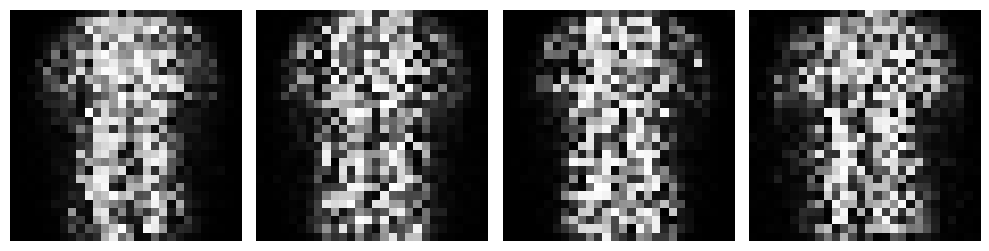

2/2 [==============================] - 0s 5ms/step
Epoch: 131, Batch: 0, D Loss: 0.692797064781189, D Acc: 0.49000000953674316, G Loss: 0.8022428750991821
2/2 [==============================] - 0s 6ms/step
Epoch: 131, Batch: 50, D Loss: 0.6910926401615143, D Acc: 0.5, G Loss: 0.798097550868988
2/2 [==============================] - 0s 5ms/step
Epoch: 131, Batch: 100, D Loss: 0.6897036135196686, D Acc: 0.5, G Loss: 0.8028070330619812
2/2 [==============================] - 0s 5ms/step
Epoch: 132, Batch: 0, D Loss: 0.6870817840099335, D Acc: 0.5, G Loss: 0.8020842671394348
2/2 [==============================] - 0s 4ms/step
Epoch: 132, Batch: 50, D Loss: 0.689707487821579, D Acc: 0.5, G Loss: 0.8054766654968262
2/2 [==============================] - 0s 12ms/step
Epoch: 132, Batch: 100, D Loss: 0.6912759840488434, D Acc: 0.5, G Loss: 0.8070597648620605
2/2 [==============================] - 0s 5ms/step
Epoch: 133, Batch: 0, D Loss: 0.6878363192081451, D Acc: 0.5, G Loss: 0.8016895055770874


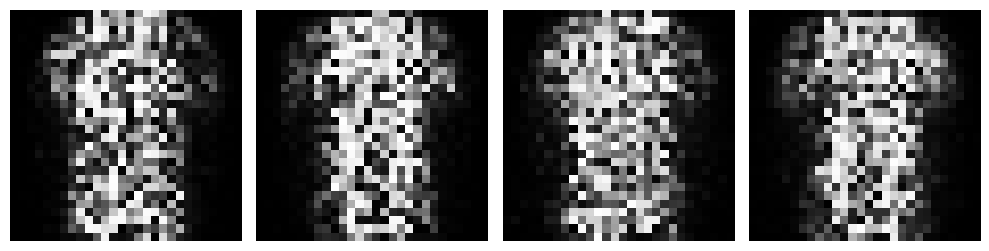

2/2 [==============================] - 0s 5ms/step
Epoch: 141, Batch: 0, D Loss: 0.6917562186717987, D Acc: 0.5, G Loss: 0.8018145561218262
2/2 [==============================] - 0s 4ms/step
Epoch: 141, Batch: 50, D Loss: 0.6903746128082275, D Acc: 0.5, G Loss: 0.7973620891571045
2/2 [==============================] - 0s 5ms/step
Epoch: 141, Batch: 100, D Loss: 0.6957677006721497, D Acc: 0.5, G Loss: 0.7954459190368652
2/2 [==============================] - 0s 4ms/step
Epoch: 142, Batch: 0, D Loss: 0.692939281463623, D Acc: 0.5, G Loss: 0.7969976663589478
2/2 [==============================] - 0s 6ms/step
Epoch: 142, Batch: 50, D Loss: 0.6902283132076263, D Acc: 0.5, G Loss: 0.7984896302223206
2/2 [==============================] - 0s 4ms/step
Epoch: 142, Batch: 100, D Loss: 0.6925862729549408, D Acc: 0.5, G Loss: 0.8029035329818726
2/2 [==============================] - 0s 6ms/step
Epoch: 143, Batch: 0, D Loss: 0.6968195140361786, D Acc: 0.4699999988079071, G Loss: 0.7834091186523438


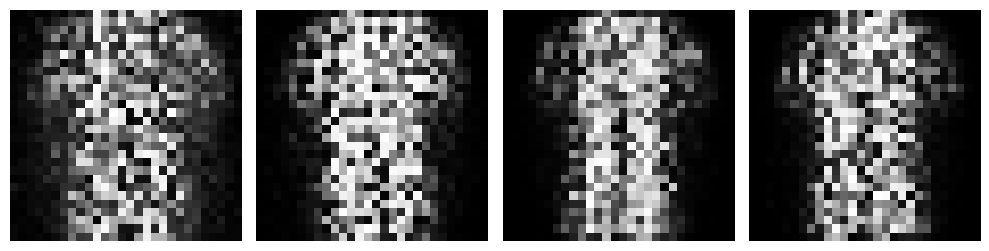

2/2 [==============================] - 0s 5ms/step
Epoch: 151, Batch: 0, D Loss: 0.6934635937213898, D Acc: 0.5, G Loss: 0.789099931716919
2/2 [==============================] - 0s 5ms/step
Epoch: 151, Batch: 50, D Loss: 0.6899861097335815, D Acc: 0.49000000953674316, G Loss: 0.7943487763404846
2/2 [==============================] - 0s 5ms/step
Epoch: 151, Batch: 100, D Loss: 0.6922725737094879, D Acc: 0.5, G Loss: 0.8017925024032593
2/2 [==============================] - 0s 5ms/step
Epoch: 152, Batch: 0, D Loss: 0.6946718990802765, D Acc: 0.5, G Loss: 0.798613429069519
2/2 [==============================] - 0s 4ms/step
Epoch: 152, Batch: 50, D Loss: 0.6929642856121063, D Acc: 0.49000000953674316, G Loss: 0.8026912808418274
2/2 [==============================] - 0s 5ms/step
Epoch: 152, Batch: 100, D Loss: 0.6905210018157959, D Acc: 0.5, G Loss: 0.7997653484344482
2/2 [==============================] - 0s 3ms/step
Epoch: 153, Batch: 0, D Loss: 0.6914744973182678, D Acc: 0.5, G Loss: 0.8

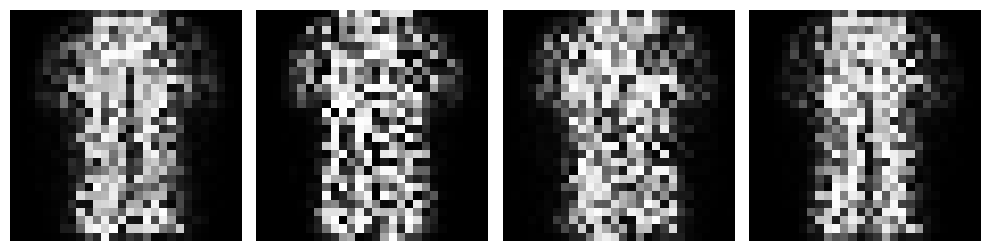

2/2 [==============================] - 0s 4ms/step
Epoch: 161, Batch: 0, D Loss: 0.6896284520626068, D Acc: 0.5, G Loss: 0.7962760925292969
2/2 [==============================] - 0s 5ms/step
Epoch: 161, Batch: 50, D Loss: 0.6899222731590271, D Acc: 0.5, G Loss: 0.7951543927192688
2/2 [==============================] - 0s 6ms/step
Epoch: 161, Batch: 100, D Loss: 0.6929606199264526, D Acc: 0.5, G Loss: 0.7988184094429016
2/2 [==============================] - 0s 4ms/step
Epoch: 162, Batch: 0, D Loss: 0.6924390196800232, D Acc: 0.5, G Loss: 0.8050763607025146
2/2 [==============================] - 0s 4ms/step
Epoch: 162, Batch: 50, D Loss: 0.6860686838626862, D Acc: 0.5, G Loss: 0.8101646304130554
2/2 [==============================] - 0s 4ms/step
Epoch: 162, Batch: 100, D Loss: 0.690552145242691, D Acc: 0.5, G Loss: 0.8062757849693298
2/2 [==============================] - 0s 5ms/step
Epoch: 163, Batch: 0, D Loss: 0.6936810910701752, D Acc: 0.5, G Loss: 0.7943309545516968
2/2 [==========

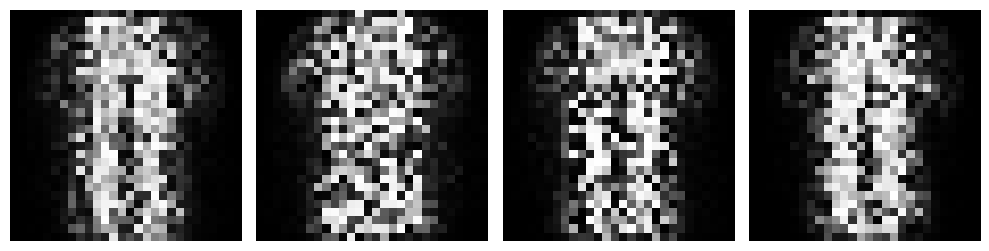

2/2 [==============================] - 0s 4ms/step
Epoch: 171, Batch: 0, D Loss: 0.6941602230072021, D Acc: 0.5, G Loss: 0.7960922122001648
2/2 [==============================] - 0s 5ms/step
Epoch: 171, Batch: 50, D Loss: 0.6897378265857697, D Acc: 0.5, G Loss: 0.7993617057800293
2/2 [==============================] - 0s 4ms/step
Epoch: 171, Batch: 100, D Loss: 0.6906180679798126, D Acc: 0.5, G Loss: 0.796510636806488
2/2 [==============================] - 0s 5ms/step
Epoch: 172, Batch: 0, D Loss: 0.6860756278038025, D Acc: 0.5, G Loss: 0.7968502044677734
2/2 [==============================] - 0s 4ms/step
Epoch: 172, Batch: 50, D Loss: 0.689489096403122, D Acc: 0.5, G Loss: 0.7984318733215332
2/2 [==============================] - 0s 5ms/step
Epoch: 172, Batch: 100, D Loss: 0.6913540959358215, D Acc: 0.5, G Loss: 0.7914647459983826
2/2 [==============================] - 0s 4ms/step
Epoch: 173, Batch: 0, D Loss: 0.6889380216598511, D Acc: 0.5, G Loss: 0.7965881824493408
2/2 [===========

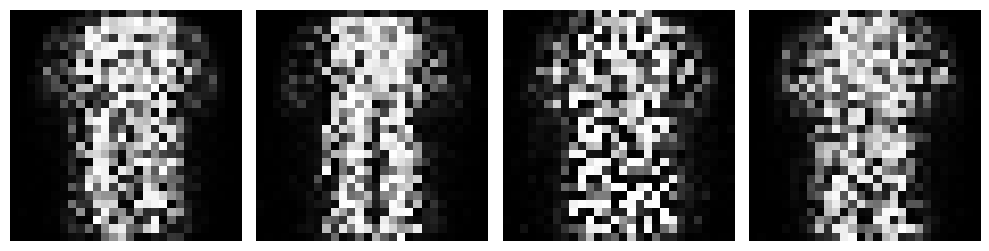

2/2 [==============================] - 0s 3ms/step
Epoch: 181, Batch: 0, D Loss: 0.6896586418151855, D Acc: 0.5, G Loss: 0.7943637371063232
2/2 [==============================] - 0s 3ms/step
Epoch: 181, Batch: 50, D Loss: 0.6881238520145416, D Acc: 0.5, G Loss: 0.796739935874939
2/2 [==============================] - 0s 8ms/step
Epoch: 181, Batch: 100, D Loss: 0.689569503068924, D Acc: 0.5, G Loss: 0.7962332367897034
2/2 [==============================] - 0s 4ms/step
Epoch: 182, Batch: 0, D Loss: 0.6864801049232483, D Acc: 0.5, G Loss: 0.7977621555328369
2/2 [==============================] - 0s 6ms/step
Epoch: 182, Batch: 50, D Loss: 0.6889896988868713, D Acc: 0.5, G Loss: 0.7980319261550903
2/2 [==============================] - 0s 4ms/step
Epoch: 182, Batch: 100, D Loss: 0.6885211765766144, D Acc: 0.5, G Loss: 0.7965011596679688
2/2 [==============================] - 0s 6ms/step
Epoch: 183, Batch: 0, D Loss: 0.6908354163169861, D Acc: 0.5, G Loss: 0.7964721918106079
2/2 [===========

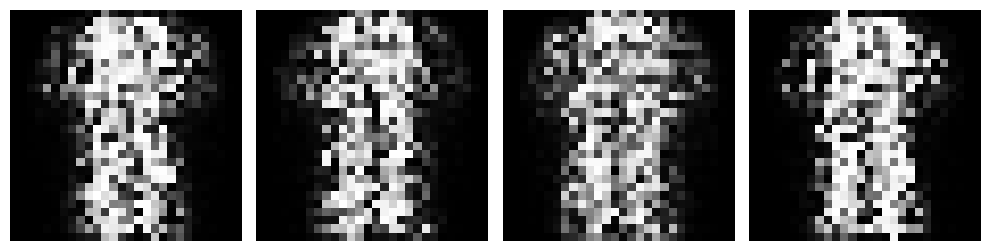

2/2 [==============================] - 0s 5ms/step
Epoch: 191, Batch: 0, D Loss: 0.6932985782623291, D Acc: 0.5, G Loss: 0.8032069206237793
2/2 [==============================] - 0s 4ms/step
Epoch: 191, Batch: 50, D Loss: 0.6843588650226593, D Acc: 0.5, G Loss: 0.7987787127494812
2/2 [==============================] - 0s 5ms/step
Epoch: 191, Batch: 100, D Loss: 0.690706193447113, D Acc: 0.5, G Loss: 0.7935742139816284
2/2 [==============================] - 0s 6ms/step
Epoch: 192, Batch: 0, D Loss: 0.6916021704673767, D Acc: 0.5, G Loss: 0.7963486313819885
2/2 [==============================] - 0s 6ms/step
Epoch: 192, Batch: 50, D Loss: 0.6888120174407959, D Acc: 0.5, G Loss: 0.7980183959007263
2/2 [==============================] - 0s 5ms/step
Epoch: 192, Batch: 100, D Loss: 0.6878615617752075, D Acc: 0.5, G Loss: 0.7963550090789795
2/2 [==============================] - 0s 9ms/step
Epoch: 193, Batch: 0, D Loss: 0.6911121308803558, D Acc: 0.5, G Loss: 0.7956100702285767
2/2 [==========

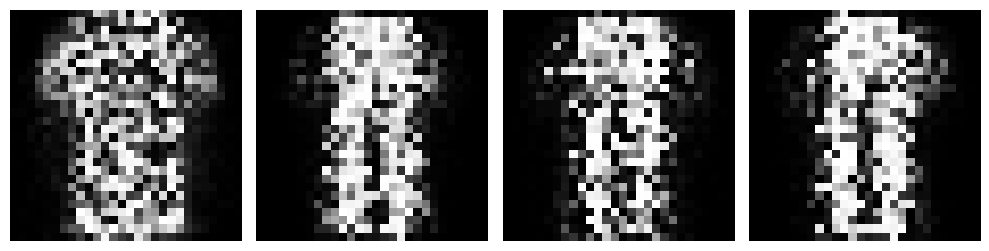

2/2 [==============================] - 0s 4ms/step
Epoch: 201, Batch: 0, D Loss: 0.6911298930644989, D Acc: 0.5, G Loss: 0.7897698879241943
2/2 [==============================] - 0s 5ms/step
Epoch: 201, Batch: 50, D Loss: 0.6888827383518219, D Acc: 0.5, G Loss: 0.7960479855537415
2/2 [==============================] - 0s 6ms/step
Epoch: 201, Batch: 100, D Loss: 0.6903150975704193, D Acc: 0.5, G Loss: 0.8009001016616821
2/2 [==============================] - 0s 5ms/step
Epoch: 202, Batch: 0, D Loss: 0.6889865696430206, D Acc: 0.5, G Loss: 0.7960646748542786
2/2 [==============================] - 0s 4ms/step
Epoch: 202, Batch: 50, D Loss: 0.6878719329833984, D Acc: 0.5, G Loss: 0.7963060140609741
2/2 [==============================] - 0s 7ms/step
Epoch: 202, Batch: 100, D Loss: 0.6907742619514465, D Acc: 0.5, G Loss: 0.7927998900413513
2/2 [==============================] - 0s 5ms/step
Epoch: 203, Batch: 0, D Loss: 0.6908602714538574, D Acc: 0.5, G Loss: 0.793621838092804
2/2 [==========

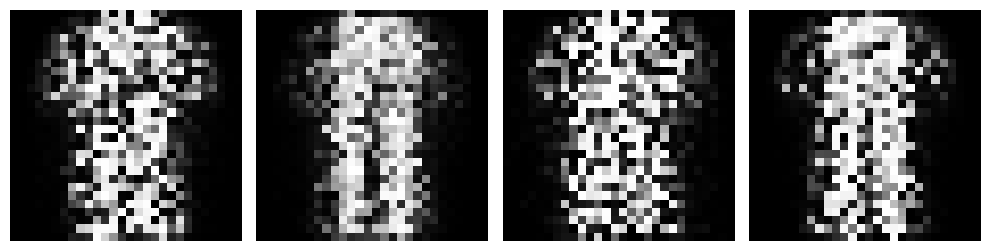

2/2 [==============================] - 0s 6ms/step
Epoch: 211, Batch: 0, D Loss: 0.6888214647769928, D Acc: 0.5, G Loss: 0.7898690700531006
2/2 [==============================] - 0s 6ms/step
Epoch: 211, Batch: 50, D Loss: 0.6887089014053345, D Acc: 0.5, G Loss: 0.7929033637046814
2/2 [==============================] - 0s 4ms/step
Epoch: 211, Batch: 100, D Loss: 0.6877040266990662, D Acc: 0.5, G Loss: 0.7970905900001526
2/2 [==============================] - 0s 6ms/step
Epoch: 212, Batch: 0, D Loss: 0.6916690766811371, D Acc: 0.5, G Loss: 0.7949325442314148
2/2 [==============================] - 0s 6ms/step
Epoch: 212, Batch: 50, D Loss: 0.6859150230884552, D Acc: 0.5, G Loss: 0.7979840636253357
2/2 [==============================] - 0s 4ms/step
Epoch: 212, Batch: 100, D Loss: 0.6896410584449768, D Acc: 0.5, G Loss: 0.7961289286613464
2/2 [==============================] - 0s 3ms/step
Epoch: 213, Batch: 0, D Loss: 0.6891537010669708, D Acc: 0.5, G Loss: 0.7913755774497986
2/2 [=========

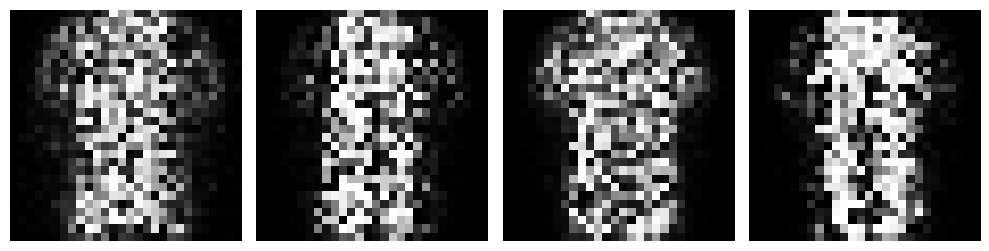

2/2 [==============================] - 0s 5ms/step
Epoch: 221, Batch: 0, D Loss: 0.6890413165092468, D Acc: 0.5, G Loss: 0.8025604486465454
2/2 [==============================] - 0s 5ms/step
Epoch: 221, Batch: 50, D Loss: 0.6891993880271912, D Acc: 0.5, G Loss: 0.7962757349014282
2/2 [==============================] - 0s 5ms/step
Epoch: 221, Batch: 100, D Loss: 0.6928252577781677, D Acc: 0.5, G Loss: 0.7953135967254639
2/2 [==============================] - 0s 4ms/step
Epoch: 222, Batch: 0, D Loss: 0.6905814409255981, D Acc: 0.5, G Loss: 0.7933447360992432
2/2 [==============================] - 0s 5ms/step
Epoch: 222, Batch: 50, D Loss: 0.6912903487682343, D Acc: 0.5, G Loss: 0.7932338118553162
2/2 [==============================] - 0s 5ms/step
Epoch: 222, Batch: 100, D Loss: 0.6907245218753815, D Acc: 0.5, G Loss: 0.7920554876327515
2/2 [==============================] - 0s 4ms/step
Epoch: 223, Batch: 0, D Loss: 0.6889318227767944, D Acc: 0.5, G Loss: 0.7949246764183044
2/2 [=========

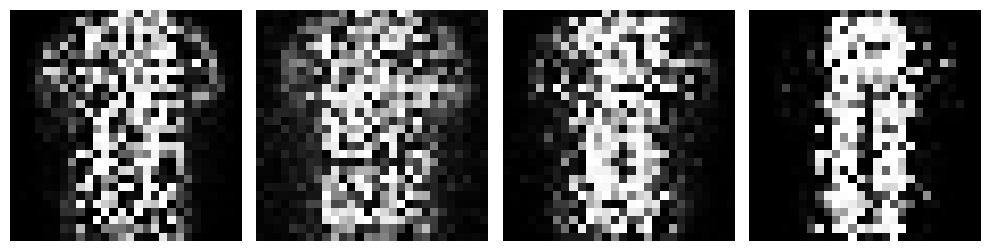

2/2 [==============================] - 0s 5ms/step
Epoch: 231, Batch: 0, D Loss: 0.6892088949680328, D Acc: 0.5, G Loss: 0.7927143573760986
2/2 [==============================] - 0s 5ms/step
Epoch: 231, Batch: 50, D Loss: 0.6906306445598602, D Acc: 0.5, G Loss: 0.7930795550346375
2/2 [==============================] - 0s 6ms/step
Epoch: 231, Batch: 100, D Loss: 0.6901030242443085, D Acc: 0.5, G Loss: 0.7959922552108765
2/2 [==============================] - 0s 5ms/step
Epoch: 232, Batch: 0, D Loss: 0.688261091709137, D Acc: 0.5, G Loss: 0.7930869460105896
2/2 [==============================] - 0s 6ms/step
Epoch: 232, Batch: 50, D Loss: 0.6896410584449768, D Acc: 0.5, G Loss: 0.7925616502761841
2/2 [==============================] - 0s 4ms/step
Epoch: 232, Batch: 100, D Loss: 0.6886644065380096, D Acc: 0.5, G Loss: 0.7979267835617065
2/2 [==============================] - 0s 4ms/step
Epoch: 233, Batch: 0, D Loss: 0.690288245677948, D Acc: 0.5, G Loss: 0.7932733297348022
2/2 [===========

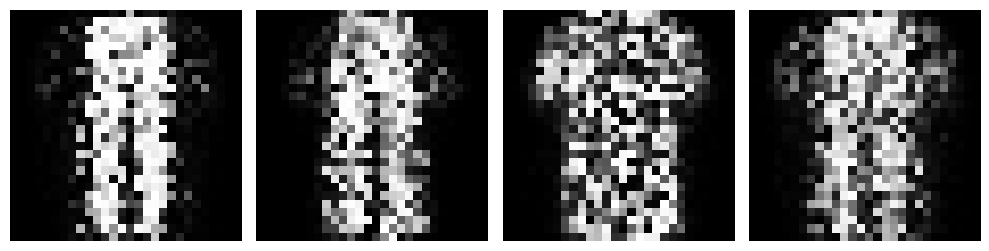

2/2 [==============================] - 0s 4ms/step
Epoch: 241, Batch: 0, D Loss: 0.6890071034431458, D Acc: 0.5, G Loss: 0.7989637851715088
2/2 [==============================] - 0s 6ms/step
Epoch: 241, Batch: 50, D Loss: 0.6888026595115662, D Acc: 0.5, G Loss: 0.8032634854316711
2/2 [==============================] - 0s 9ms/step
Epoch: 241, Batch: 100, D Loss: 0.6888341307640076, D Acc: 0.5, G Loss: 0.7954506874084473
2/2 [==============================] - 0s 6ms/step
Epoch: 242, Batch: 0, D Loss: 0.6882439255714417, D Acc: 0.5, G Loss: 0.7965001463890076
2/2 [==============================] - 0s 8ms/step
Epoch: 242, Batch: 50, D Loss: 0.6877554059028625, D Acc: 0.5, G Loss: 0.7907504439353943
2/2 [==============================] - 0s 5ms/step
Epoch: 242, Batch: 100, D Loss: 0.6905453205108643, D Acc: 0.5, G Loss: 0.7943623065948486
2/2 [==============================] - 0s 5ms/step
Epoch: 243, Batch: 0, D Loss: 0.6895909011363983, D Acc: 0.5, G Loss: 0.7994875907897949
2/2 [=========

In [ ]:
import matplotlib.pyplot as plt

def train_gan(gan_model, generator, discriminator, train_data, epochs, batch_size, noise_dim, total_class):
    half_batch = batch_size // 2

    def get_fake_sample():
        noise = np.random.randn(half_batch, noise_dim)
        labels = np.random.randint(0, total_class, half_batch).reshape(-1, 1)
        return noise, labels

    def get_real_sample():
        idx = np.random.randint(0, train_data.shape[0], half_batch)
        real_images = train_data[idx]
        return real_images

    def preview_generated_images(generator, noise_dim, total_class, n_samples=4):
        noise = np.random.randn(n_samples, noise_dim)
        labels = np.random.randint(0, total_class, n_samples).reshape(-1, 1)
        generated_images = generator.predict([noise, labels])

        fig, axes = plt.subplots(1, n_samples, figsize=(10, 5))
        for i, ax in enumerate(axes.flat):
            ax.imshow(generated_images[i].squeeze(), cmap='gray')
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    for epoch in range(epochs):
        if epoch % 10 == 0:
            preview_generated_images(generator, noise_dim, total_class, n_samples=4)

        for _ in range(epochs // 2):
            noise, fake_labels = get_fake_sample()
            fake_images = generator.predict([noise, fake_labels])

            real_images = get_real_sample()
            real_labels = np.random.randint(0, total_class, half_batch).reshape(-1, 1)

            y_real = np.ones((half_batch, 1)) * 0.9
            y_fake = np.zeros((half_batch, 1))

            discriminator.trainable = True
            real_discriminator_loss = discriminator.train_on_batch([real_images, real_labels], y_real)
            fake_discriminator_loss = discriminator.train_on_batch([fake_images, fake_labels], y_fake)
            total_discriminator_loss = 0.5 * np.add(real_discriminator_loss, fake_discriminator_loss)

            discriminator.trainable = False
            noise, fake_labels = get_fake_sample()
            y_generator = np.ones((half_batch, 1))
            generator_loss = gan_model.train_on_batch([noise, fake_labels], y_generator)

            if _ % 50 == 0:
                print(f"Epoch: {epoch + 1}, Batch: {_}, D Loss: {total_discriminator_loss[0]}, D Acc: {total_discriminator_loss[1]}, G Loss: {generator_loss}")

train_gan(gan_model, generator_model, discriminator_model, filter_img_data, epochs=250, batch_size=100, noise_dim=noise_dim, total_class=total_class)


In [ ]:
from scipy import linalg

def fid_score(real_images, generated_images):
    if real_images.ndim > 2:
        real_images = real_images.reshape(real_images.shape[0], -1)
    if generated_images.ndim > 2:
        generated_images = generated_images.reshape(generated_images.shape[0], -1)

    mu_real = np.mean(real_images, axis=0)
    sigma_real = np.cov(real_images, rowvar=False)
    mu_gen = np.mean(generated_images, axis=0)
    sigma_gen = np.cov(generated_images, rowvar=False)

    mean_diff = np.sum((mu_real - mu_gen) ** 2)
    cov_sqrt = linalg.sqrtm(sigma_real.dot(sigma_gen), disp=False)[0].real

    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real

    fid = mean_diff + np.trace(sigma_real + sigma_gen - 2 * cov_sqrt)
    return fid

def evaluate_fid(generator, gan_model, train_data, noise_dim, total_class, batch_size=100): # Added batch_size
    all_score = np.empty(50)

    # Moved the sampling functions outside train_gan and into evaluate_fid
    def get_fake_sample(batch_size, noise_dim, total_class):
        noise = np.random.randn(batch_size // 2, noise_dim)
        labels = np.random.randint(0, total_class, batch_size // 2).reshape(-1, 1)
        return noise, labels

    def get_real_sample(train_data, batch_size):
        idx = np.random.randint(0, train_data.shape[0], batch_size // 2)
        real_images = train_data[idx]
        return real_images

    # Call the sampling functions that are now within scope
    noise, fake_labels = get_fake_sample(batch_size, noise_dim, total_class)
    real_images = get_real_sample(train_data, batch_size)

    for i in range(50):
        fake_images = generator.predict([noise, fake_labels])
        all_score[i] = fid_score(real_images[i], fake_images[i])

    print('Avg. FID : ', np.mean(all_score).round(3))
    print('Std. FID :', np.std(all_score).round(3))

evaluate_fid(generator_model, gan_model, filter_img_data, noise_dim, total_class)

2/2 [==============================] - 0s 4ms/step
Avg. FID :  10.04
Std. FID : 5.271


Hasil FID pada model ini adalah 10.04, menandakan bahwa gambar yang dihasilkan oleh GAN sangat mirip dengan data aslinya hingga diskriminator mengira gambar yang dibuat merupakan gambar asli. Selain itu, standar deviasi FID nya adalah 5.271, menandakan bahwa variasi dari kualitas gambar relatif kecil.